# IMPORTING MODULES

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.combine import SMOTEENN

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings("ignore")

- **[LOAD THE DATA](#load_data)**
- **[CHECK THE DATA](#check_data)**
- **[CLEAN THE DATA](#clean_data)**
- **[DATA ANALYSIS](#data_analysis)**
    - [Univariate Analysis](#uni)
    - [Bivariate Analysis](#biv)
    - [Insights](#insights)
- **[FORMAT DATA](#format_data)**
    - [Analyze Encoded Data](#analyze_encoded)
- **[BUILDING A MODEL](#build_model)**
    - [Training and Testing](#training_testing)
    - [Picking the Model](#pick_model)
- **[SUGGESTED SOLUTIONS](#suggested_solutions)**

----

<a id="load_data"></a>
# LOAD THE DATA

The dataset is from kaggle, specifically the **[Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)**. Customer churn prediction is to measure why customers are leaving a business.

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Delete duplicates

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


The columns are...
- **customerID**, The ID number assigned to each customer
- **gender**
- **SeniorCitizen**
- **Partner**, If the customer has a partner
- **Dependents**, Relatives of the customer
- **tenure**, how long in months does the customer stayed or staying in the business
- **PhoneService**
- **MultipleLines**, Does the customer have multiple lines in the phone service
- **InternetService**, Type of internet Service `[DSL, Fiber Optic]` or None
- **OnlineSecurity**
- **OnlineBackup**
- **DeviceProtection**
- **TechSupport**
- **StreamingTV**
- **StreamingMovies**
- **Contract**, Either `[Month-to-Month, One year, Two year]`
- **PaperlessBilling**
- **PaymentMethod**, Either `[Electronic check, Mailed check, Bank transfer (automatic),Credit card (automatic)]`
- **MonthlyCharges**
- **TotalCharges**
- **Churn**, If the customer left the business

The **Churn** column is what we're going to predict.

----

<a id="check_data"></a>
# CHECK THE DATA

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Something's fishy about the minimum value of `tenure` which is 0. It can mean that this are new customers that uses the services. It means there's a chance that the `TotalCharges` will be empty or null.

Let's check for more info...

In [6]:
df[df['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


As we can see under `Total Charges`, the value is also null or empty. This can also mean that the dtype for this feature is wrong.

Let's check for more info...

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


As we can see, the dtype for `TotalCharges` is object rather than a float or int.

Also there are no null values. But we still have to check if there are empty values for each column since the `TotalCharges` is not null even though it's empty

In [8]:
len(df[df['TotalCharges'].isnull()])

0

Using the method above doesn't capture that kind of empty. We will use this instead.

In [9]:
len(df[df['TotalCharges'] == " "])

11

In [10]:
def get_null(df):
    for column in df.columns:
        print(f'{column}:', len(df[df[column] == " "]))

In [11]:
get_null(df)

customerID: 0
gender: 0
SeniorCitizen: 0
Partner: 0
Dependents: 0
tenure: 0
PhoneService: 0
MultipleLines: 0
InternetService: 0
OnlineSecurity: 0
OnlineBackup: 0
DeviceProtection: 0
TechSupport: 0
StreamingTV: 0
StreamingMovies: 0
Contract: 0
PaperlessBilling: 0
PaymentMethod: 0
MonthlyCharges: 0
TotalCharges: 11
Churn: 0


This shows that `TotalCharges` is the only column with empty values.

----

<a id="clean_data"></a>
# CLEAN THE DATA

I'll delete the `customerID` column since it has no use predicting the churness of a customer

In [12]:
df.drop(columns=['customerID'], inplace=True)

In [13]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


***1. Dealing with missing `TotalCharges` value***

Since we know that a tenure = 0 also correspons to a TotalCharges = Null and we've seen from above that its only 11 rows, let's compute what percentage of the total data incase we remove that rows.

In [14]:
len(df[df['TotalCharges'] == " "]) / len(df[df['TotalCharges'] != " "])*100

0.15642775881683732

It's only about 15% of the total data. So we will remove these rows. Let's check first the total rows of the data.

In [15]:
len(df)

7043

In [16]:
df = df[df['TotalCharges'] != " "]

Let's confirm that the rows are removed.

In [17]:
len(df)

7032

***2. Changing the `TotalCharges` dtype***

In [18]:
df.TotalCharges.dtype

dtype('O')

The dtype of `TotalCharges` is still wrong. Let's change this.

In [19]:
df['TotalCharges'] = pd.to_numeric(df.TotalCharges)

In [20]:
df.TotalCharges.dtype

dtype('float64')

***3. Making the tenure groups from tenure***

In [21]:
print("Min tenure months: ", df.tenure.min())
print("Max tenure months: ", df.tenure.max())

Min tenure months:  1
Max tenure months:  72


Since we have a min and max tenure months of 1 and 72. We will group them by years:
* 1 - 12, (1 year)
* 13 - 24, (2 years)
* 25 - 36, (3 years)
* 37 - 48, (4 years)
* 49 - 60, (5 years)
* 61 - 72, (6 years)

New dataframe for tenure groups

In [22]:
df_tg = df.copy()

In [23]:
def tenure_groups(column):
    tenure = column[4]
    if tenure >= 1 and tenure <= 12:
        return '1 - 12'
    elif tenure > 12 and tenure <= 24:
        return '13 - 24'
    elif tenure > 24 and tenure <= 36:
        return '25 - 36'
    elif tenure > 36 and tenure <= 48:
        return '37 - 48'
    elif tenure > 48 and tenure <= 60:
        return '49 - 60'
    else:
        return '61 - 72'

df_tg['tenure_group'] = df_tg.apply(tenure_groups, axis=1)

Drop the tenure column

In [24]:
df_tg.drop(columns=['tenure'], inplace=True)

In [25]:
df_tg.head(1)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12


After cleaning the data, let's head over to data analysis.

----

<a id="data_analysis"></a>
# DATA ANALYSIS

In [26]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


`SeniorCitizen` is just a categorical value

25% of customers has a `tenure` above 55 months or roughly 4.5 years. Most of them are loyal customers and satisfied with the service.

There is an average of 64.80 USD for the `MonthlyCharges`. 25% of the customers pay more than 90 USD.

The min `MonthlyCharges` and  min `TotalCharges` are almost thesame which means we have new customers which are also present in the min value for `tenure`.

***1. Count how many Yes churn and No churn***

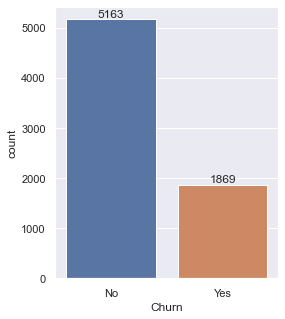

In [27]:
sns.set(rc={'figure.figsize':(4,5)})
ax=sns.countplot(x='Churn', data=df_tg)
ax.set_xticklabels(ax.get_xticklabels())
for container in ax.containers:
    ax.bar_label(container)

We can see that `No Churn` is the majority.

In [28]:
print("Not Churned: ", (len(df_tg[df_tg['Churn'] == 'No']) / len(df_tg))*100)
print("Churned: ", (len(df_tg[df_tg['Churn'] == 'Yes']) / len(df_tg))*100)

Not Churned:  73.42150170648463
Churned:  26.578498293515356


Only about 26% of the data Churned. This means we have an imbalanced dataset.

We'll analyse with other features while taking the target values separately to get some insights.

<a id="uni"></a>
***2. Univariate Analysis***

We plot each feature by churn

In [29]:
df_tg.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'tenure_group'],
      dtype='object')

In [30]:
def plot_univariate(df, feature):
    sns.set(rc={'figure.figsize':(10,5)})
    ax=sns.countplot(x=feature, data=df, hue='Churn')
    ax.set_xticklabels(ax.get_xticklabels())
    for container in ax.containers:
        ax.bar_label(container)

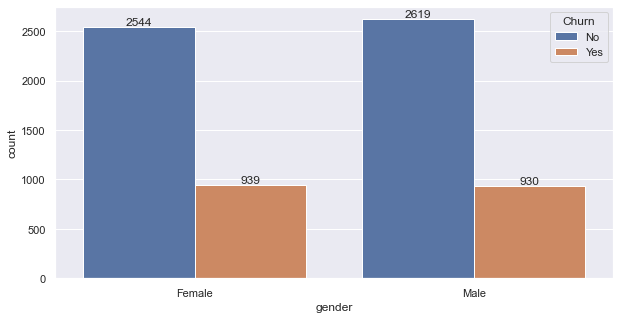

In [31]:
plot_univariate(df_tg, 'gender')

We can see here that the gender doesn't really have that much impact on churness when standalone since they are both almost equal in value. But we'll see later in the `Bivariate Analysis` if the gender can have an impact when combined with another feature. Or else we'll delete the gender.   

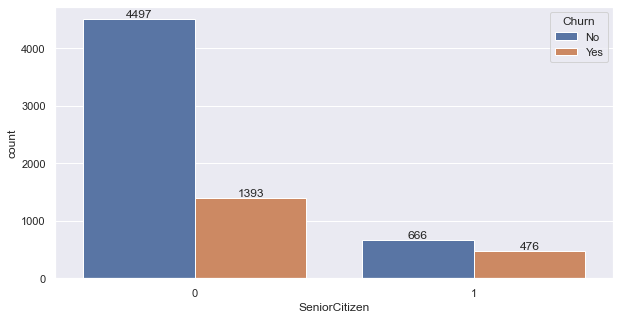

In [32]:
plot_univariate(df_tg, 'SeniorCitizen')

If the customer is not a Senior Citizen. It is most likely to churn.

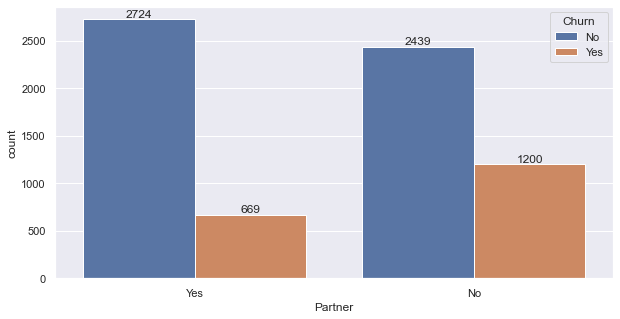

In [33]:
plot_univariate(df_tg, 'Partner')

As for the partner, majority of the customers who don't have a partner or single churned.

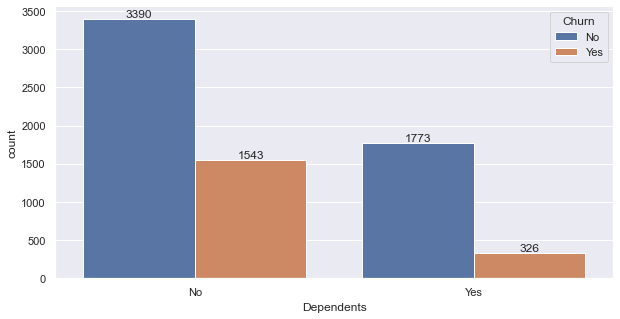

In [34]:
plot_univariate(df_tg, 'Dependents')

Again the customers who doesn't have and partner or dependents which probably are not a senior citizen which is young adults have a majority of churning.

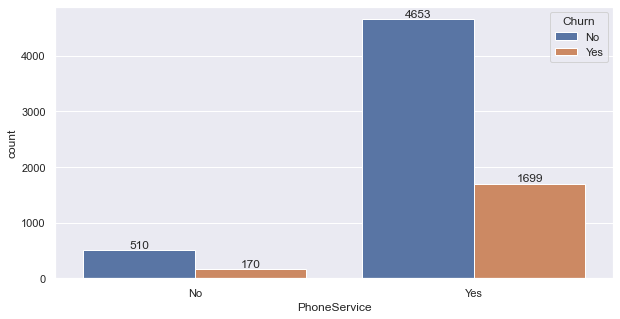

In [35]:
plot_univariate(df_tg, 'PhoneService')

Most of the customers who have phone service churned while those who don't have phone service did not churn. Maybe because they don't experience the flaws of this service.

Still, there are many customers who are satisfied with the service.

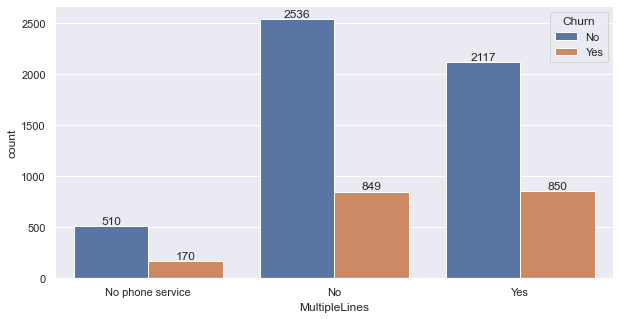

In [36]:
plot_univariate(df_tg, 'MultipleLines')

The Multiple Lines seems to have little no effect on the churness too.

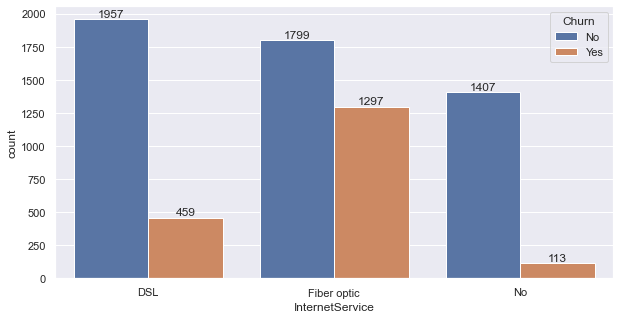

In [37]:
plot_univariate(df_tg, 'InternetService')

The customers with an internet service of Fiber optic is most likely to churn than having DSL. Maybe because The Fiber optic service is still not that good and in the process of development. Or the price too much higher.

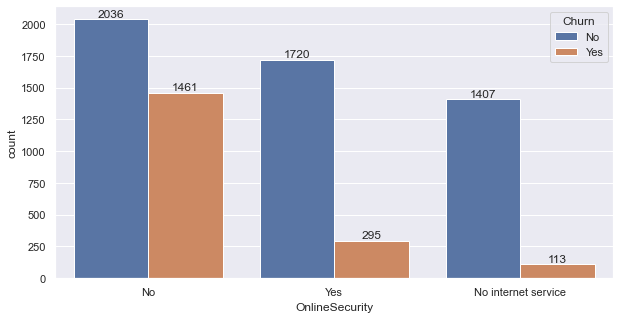

In [38]:
plot_univariate(df_tg, 'OnlineSecurity')

As you can see those who don't have an Online Security is most likely to churn since. They don't have added protection.

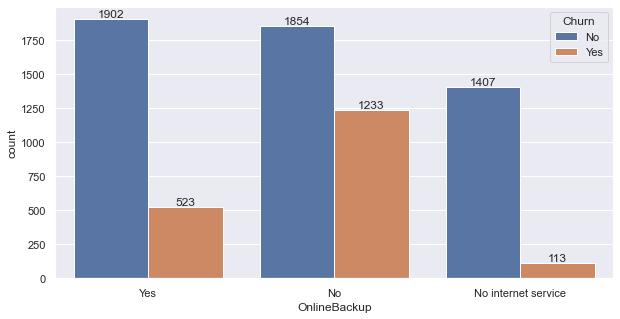

In [39]:
plot_univariate(df_tg, 'OnlineBackup')

Those who do not have an online backup is most likely to churn.

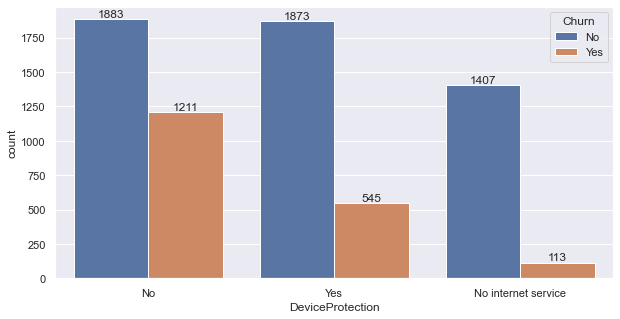

In [40]:
plot_univariate(df_tg, 'DeviceProtection')

Those who do not have device protection is mostl likely to churn.

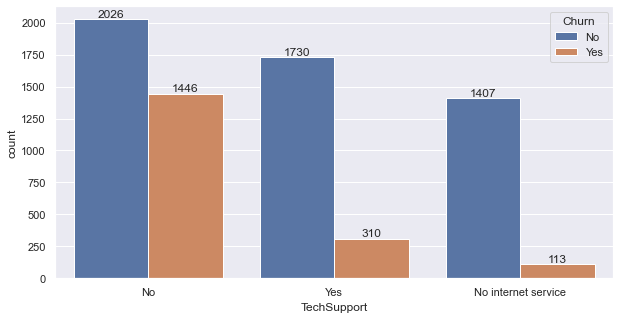

In [41]:
plot_univariate(df_tg, 'TechSupport')

Those who do not have Tech Support is most likely to churn. Maybe because they're not very knowledgeable about the technology or their ability to configure or troubleshoot is not that good. Especially when the customer is a Senior Citizen.

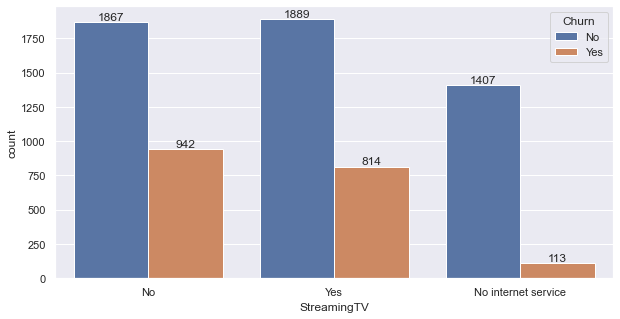

In [42]:
plot_univariate(df_tg, 'StreamingTV')

The Streaming TV also doesn't have that much effect on the churness.

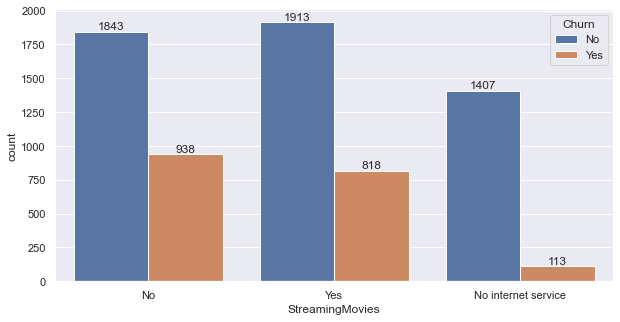

In [43]:
plot_univariate(df_tg, 'StreamingMovies')

Same with Streaming Movies.

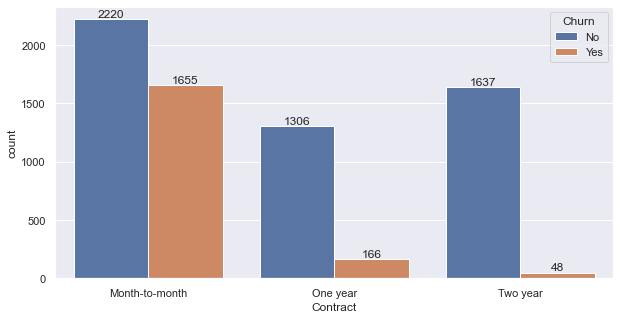

In [44]:
plot_univariate(df_tg, 'Contract')

Those customers who has only a contract of Month-to-month is most likely to churn since maybe some of them are business hopping or trying different service providers or maybe because there are no contract terms they are free to go customers. Whereas if the customer has a 2 year contract, they are unlikely to churn.

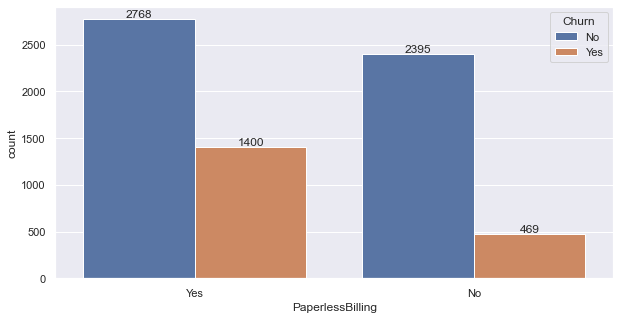

In [45]:
plot_univariate(df_tg, 'PaperlessBilling')

Surprisingly, those who have paperless billing are more likely to churn.

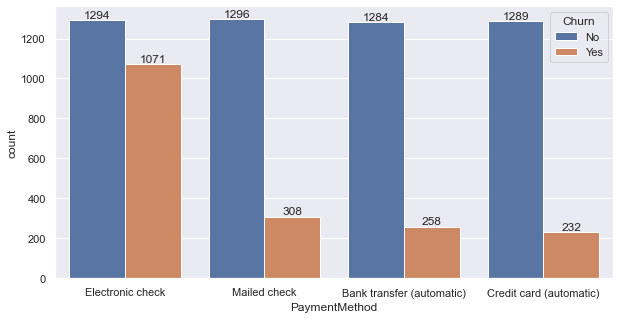

In [46]:
plot_univariate(df_tg, 'PaymentMethod')

As seen here paperless billing with Electronic check as payment method is most likely to churn. Maybe the majority of customers who have a contract of month-to-month choose this payment method.

Or maybe some customers forgot to look at their emails or notifications.

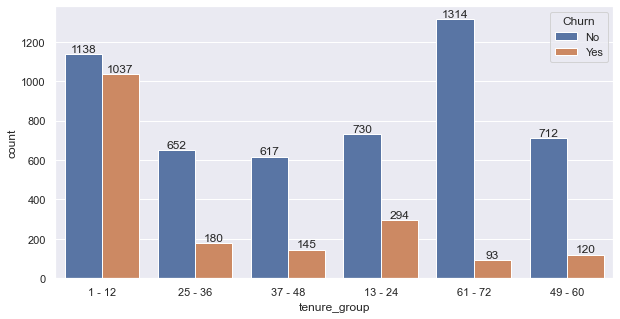

In [47]:
plot_univariate(df_tg, 'tenure_group')

The customers with tenure months of less than 1 year tends to churn. This is somehow linked to the Month to Month Contract.

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Density'>

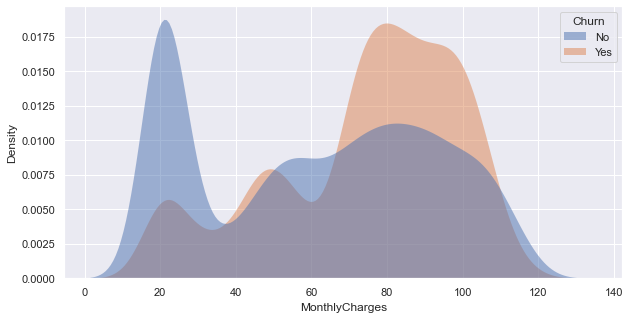

In [48]:
sns.kdeplot(
   data=df_tg, x="MonthlyCharges", hue="Churn",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0, color='Blue'
)

Most of the customers that has a high Monthly Charges is most likely to churn. This may be caused by some hidden charges experienced by some customers especially if they're new. 

Also most of them who have low monthly charges didn't churn.

<AxesSubplot:xlabel='TotalCharges', ylabel='Density'>

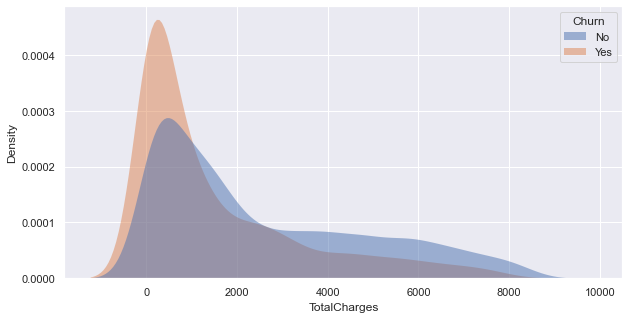

In [49]:
sns.kdeplot(
   data=df_tg, x="TotalCharges", hue="Churn",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0, color='Blue'
)

As you can see, customers with low Total charges tends to churn. This can be linked to the customers with `tenure = 1 - 12, contract = Month-to-month`, that has a high `Monthly Charges`. They have a high chance of churning if these parameters were true. **Low tenure** with **high monthly charges** with **low total charges**

<a id="biv"></a>
***3. Bivariate Analysis***

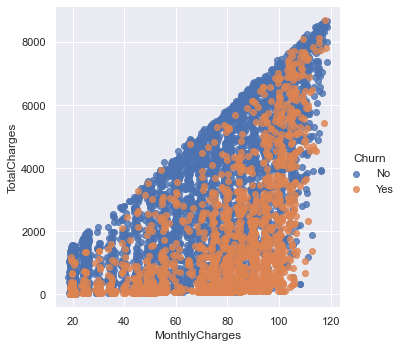

In [50]:
sns.lmplot(data=df_tg, x='MonthlyCharges', y='TotalCharges', hue='Churn', fit_reg=False)

As Monthly Charges increases, Total Charges also increases as expected.

We can also see here that some high monthly charges. Have low total charges. This is probably because they've already churned due to high monthly charges

In [51]:
def plot_bivariate(df, feature, hue, title):
    sns.set(rc={'figure.figsize':(10,5)})
    ax=sns.countplot(x=feature, data=df, hue=hue)
    ax.set_xticklabels(ax.get_xticklabels())
    plt.title(title)
    for container in ax.containers:
        ax.bar_label(container)

In [52]:
churned = df_tg[df_tg['Churn'] == "Yes"]

In [53]:
non_churned = df_tg[df_tg['Churn'] == "No"]

In [54]:
### Check to see if gender has an impact if combined with other feature 

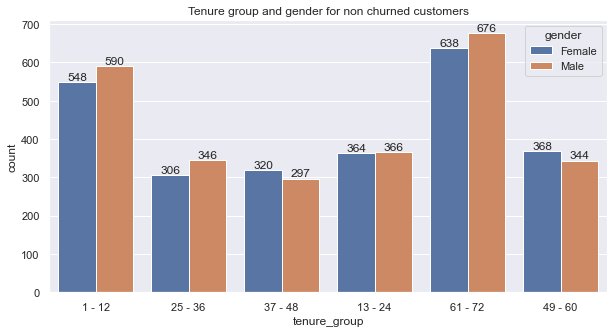

In [55]:
plot_bivariate(non_churned, 'tenure_group', 'gender', 'Tenure group and gender for non churned customers')

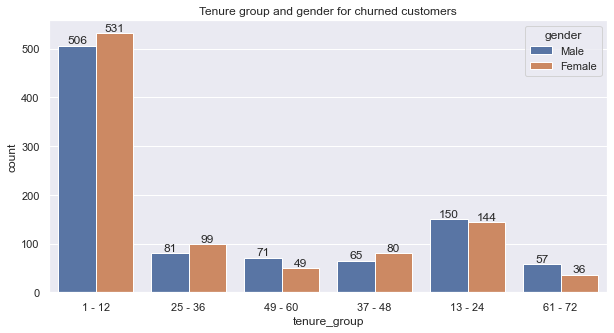

In [56]:
plot_bivariate(churned, 'tenure_group', 'gender', 'Tenure group and gender for churned customers')

Here we can see the comparison of distribution between the tenure group and gender for churned and non-churned customers.

for the `1 - 12 tenure group`, the gender is almost equal. but for other groups it's clear that if the customer is male or female that belongs to the `61-72 group`, then they are less likely to churn.

So, we will not drop the gender column.

We will further analyze the data after formatting the features with One-hot encoding.

<a id="insights"></a>
***4. Insights***

1. `Gender` seems to have no impact on churness when standalone but somehow it does when grouped with other feature.

2. Mostly young adults or younger individual tends to churn as shown in `SeniorCitizen`, `Partner`, and `Dependendts`.

3. Customers with Fiber optic as an internet service tends to churn more than DSL.

4. Customers with no additional service like `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, and `TechSupport` is more likely to churn.

5. Customers with paperless billing specifically the electronic check is more likely to churn.

6. Customers with `low tenure months` like 1-12 , with `contract` of month-to-month or one year(but less likely), with `high monthly charges`, and `low total charges` has a very high chance of churning.

----

<a id="format_data"></a>
# FORMAT DATA

***1. One-Hot Encoding***

In [57]:
# Use this function to check for unique values in every feature

def unique_values(df):
    for column in df.columns:
        print(f'{column} : {df[column].unique()}')

In [58]:
unique_values(df_tg)

gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges : [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn : ['No' 'Yes']
tenure_group : ['1 - 12' '25 - 36' '37 - 48' '13 - 24' '61 - 72' '49 - 60']


In [59]:
df_encoded = df_tg.copy()

Make a new df encoded.

Before we on-hot encode the categorical features in the new dataframe, let's first drop `Churn` and replace the `SeniorCitizen` with 0 and 1.

After that, join the `Churn` column from the df_tg dataframe then replace the values with 0 and 1.

In [60]:
df_encoded.drop(columns=['Churn'], inplace=True)
df_encoded['SeniorCitizen'].replace({0: 'No', 1: 'Yes'}, inplace=True)
df_encoded = pd.get_dummies(df_encoded)
df_encoded['Churn'] = df_tg['Churn']
df_encoded['Churn'].replace({'Yes': 1,'No': 0}, inplace=True)

<a id="analyze_encoded"></a>
***2. Analyze encoded data***

Here we make a correlation graph of each feature with respect to the dependent variable `Churn`

<AxesSubplot:>

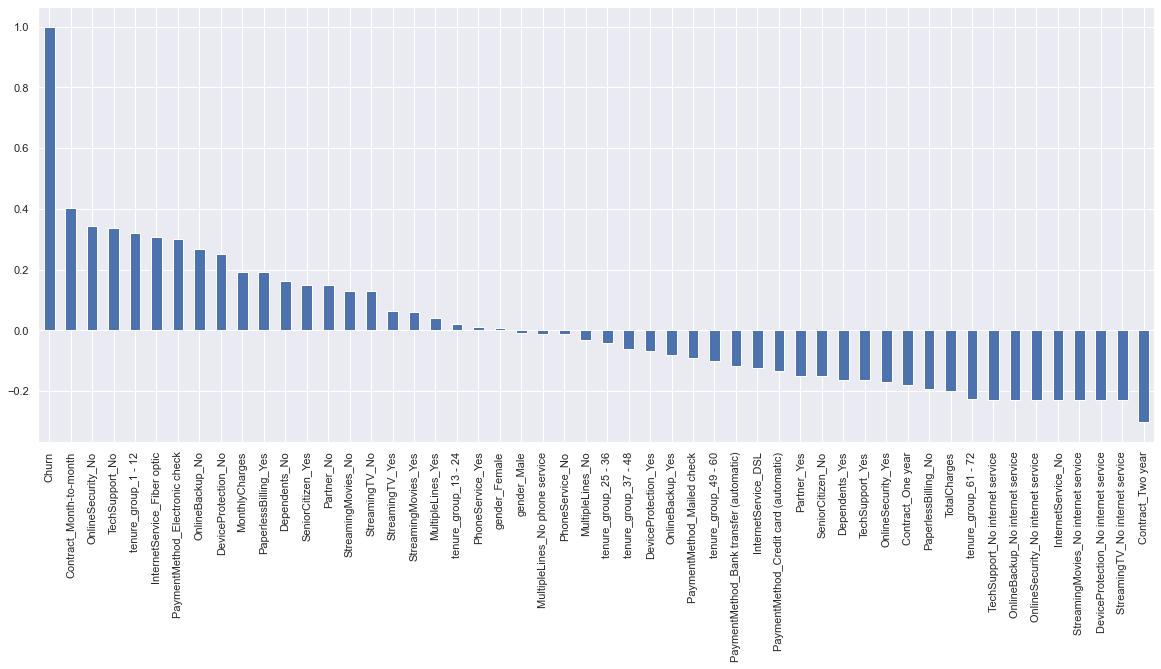

In [61]:
plt.figure(figsize=(20,8))
df_encoded.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

Here we can see that almost from `MonthlyCharges` to `TotalCharges` there is 0 to little positive and negative correlation with a value between (0.2, -0.2).

We will not remove any features yet, since some features here works when they are not standalone.

Let's further analyze it using a heatmap.

<AxesSubplot:>

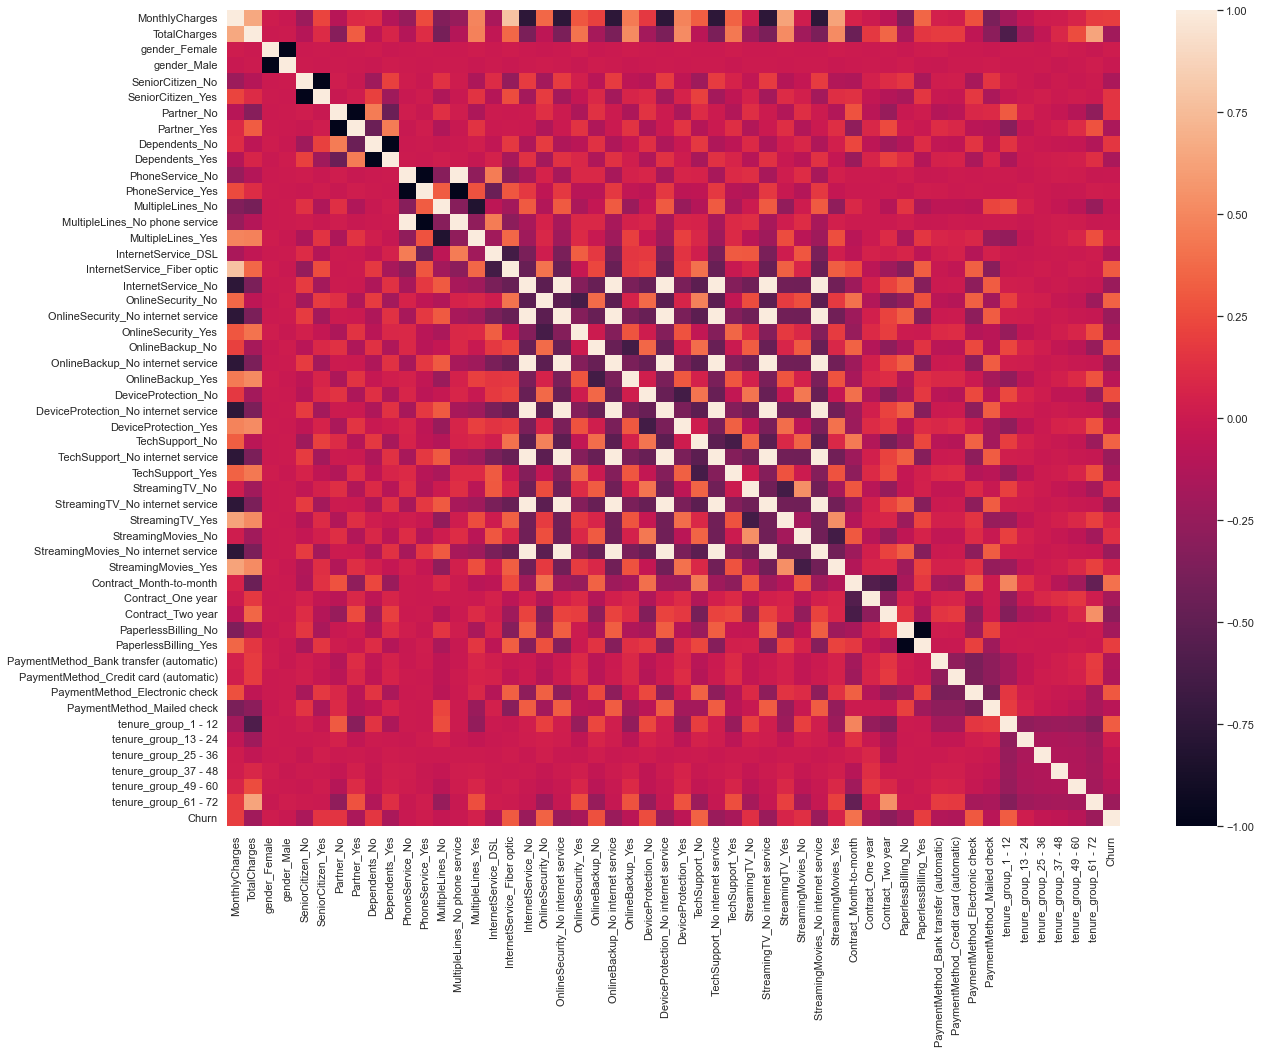

In [62]:
plt.subplots(figsize=(20,15))
sns.heatmap(df_encoded.corr(), annot=False)

We then remove the `gender_Female`, `SeniorCitizen_Yes`, `Parter_Yes`, `Dependents_Yes`, `PhoneService_Yes`, and `PaperlessBilling_No` columns since it shows a negatively correlated with their other categorical variable. Which suggests almost perfect collinearity. 

In [63]:
df_encoded.shape

(7032, 52)

In [64]:
df_encoded.drop(columns=['gender_Female', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'PaperlessBilling_No'], inplace=True)

In [65]:
df_encoded.shape

(7032, 46)

**Let's now build a model.**

----

<a id="build_model"></a>
# BUILDING A MODEL

For this dataset, `Logistic Regression` and `Artificial Neural Network` will be used.

Each function takes X_train, X_test, y_tran, y_test, and a sampling type which defaults to `None`.

Other sampling types are **Smoteenn** and **Upsampling**. These sampling techniques are only used by the ***X_train*** and ***y_train***.

Before the X_train and X_test are used by the **LR** and **ANN**. It is scaled first by `MinMaxScaler` from 0 to 1.

The logistic regression models are already optimized by the use of `GridSearchCV` with `ten-fold cross validation` shown after this cell.

In [66]:
def conf_matrix(y_test, y_pred, model):
    
    cm = metrics.confusion_matrix(y_test, y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
    ax.set_title(f'{model} Model'); 
    ax.xaxis.set_ticklabels(['not_churn', 'churn']); ax.yaxis.set_ticklabels(['not_churn', 'churn']);

    print(classification_report(y_test, y_pred))

In [80]:
#LOGITSIC REGRESSION

def logistic_regression(X_train, X_test, y_train, y_test, sampling='None'):
    
    #Scale by Min Max
    scale = preprocessing.MinMaxScaler().fit(X_train)
    X_train_scaled = scale.transform(X_train)
    X_test_scaled = scale.transform(X_test)
    
    if sampling == 'None':
        
        lr = LogisticRegression(C=1.623776739188721, max_iter=100, penalty='l1', solver='saga')
        lr.fit(X_train_scaled, y_train)
        y_pred = lr.predict(X_test_scaled)
        print("Sampling: NONE")
        conf_matrix(y_test, y_pred, 'Logistic Regression')
    
    elif sampling == 'Smoteenn':
        sm = SMOTEENN()
        X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

        lr_smoteenn = LogisticRegression(C=1.623776739188721, max_iter=100, penalty='l2', solver='lbfgs')
        lr_smoteenn.fit(X_resampled, y_resampled)
        y_pred = lr_smoteenn.predict(X_test_scaled)
        print("Sampling: SMOTEENN")
        conf_matrix(y_test, y_pred, 'Logistic Regression')
    
    elif sampling == 'Upsampling':
        y_train = pd.DataFrame(np.array(y_train)).rename(columns={0 : "Churn"})
        X_train = pd.DataFrame(X_train_scaled)
        X_d = pd.concat([X_train, y_train], axis=1)
        
        # separate majority and minority classes
        churn_0 = X_d[X_d.Churn==0]
        churn_1 = X_d[X_d.Churn==1]
        
        # upsample minority
        churn_1_upsampled = resample(churn_1,
                          replace=True, # sample with replacement
                          n_samples=len(churn_0), # match number in majority class
                          random_state=42) # reproducible results

        # combine majority and upsampled minority
        churn_upsampled = pd.concat([churn_0, churn_1_upsampled])
        
        # Make new X_train and y_train
        X_train = churn_upsampled.drop(columns=['Churn']  )
        y_train = churn_upsampled['Churn']
        
        lr_upsampling = LogisticRegression(C=0.03359818286283781, max_iter=100, penalty='l2', solver='lbfgs')
        lr_upsampling.fit(X_train, y_train)

        y_pred = lr_upsampling.predict(X_test_scaled)
        print("Sampling: UPSAMPLING")
        conf_matrix(y_test, y_pred, 'Logistic Regression')
        
    else:
        print("Invalid Sampling")

> Gridsearch for **LR** with sampling `None`

In [720]:
param_grid = [
  {'penalty': ['l1', 'l2', 'elasticnet', 'none'], #L1 - Lasso regression, L2 - Ridge Regression, elasticnet - both
   'C' : np.logspace(-4, 4, 20), # Returns 20 evenly spaced on a log scale From 10**-4 to 10**4 
   'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'], 
   'max_iter': [100, 1000, 2500, 5000]},
]

optimal_params = GridSearchCV( 
        LogisticRegression(), 
        param_grid, 
        cv=10,
        scoring='accuracy',
    )
b
optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1.623776739188721, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


> Gridsearch for **LR** with sampling `Smoteenn`

In [746]:
param_grid = [
  {'penalty': ['l1', 'l2', 'elasticnet', 'none'], #L1 - Lasso regression, L2 - Ridge Regression, elasticnet - both
   'C' : np.logspace(-4, 4, 20), # Returns 20 evenly spaced on a log scale From 10**-4 to 10**4 
   'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'], 
   'max_iter': [100, 1000, 2500, 5000]},
]

optimal_params = GridSearchCV( 
        LogisticRegression(), 
        param_grid, 
        cv=10,
        scoring='accuracy',
    )

optimal_params.fit(X_resampled, y_resampled)
print(optimal_params.best_params_)

{'C': 1.623776739188721, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


> Gridsearch for **LR** with sampling `Upsampling`

In [750]:
param_grid = [
  {'penalty': ['l1', 'l2', 'elasticnet', 'none'], #L1 - Lasso regression, L2 - Ridge Regression, elasticnet - both
   'C' : np.logspace(-4, 4, 20), # Returns 20 evenly spaced on a log scale From 10**-4 to 10**4 
   'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'], 
   'max_iter': [100, 1000, 2500, 5000]},
]

optimal_params = GridSearchCV( 
        LogisticRegression(), 
        param_grid, 
        cv=10,
        scoring='accuracy',
    )

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

{'C': 0.03359818286283781, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


For the **ANN**, 

In [68]:
# ARTIFICIAL NEURAL NETWORK

def ann(X_train, X_test, y_train, y_test, sampling='None'):
    
    #Scale by Min Max
    scale = preprocessing.MinMaxScaler().fit(X_train)
    X_train_scaled = scale.transform(X_train)
    X_test_scaled = scale.transform(X_test)
    
    if sampling == 'None':
        
        model = keras.Sequential([
            keras.layers.Dense(1000, input_shape=(45,), activation='relu'),
            keras.layers.Dense(500, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])

        # opt = keras.optimizers.Adam(learning_rate=0.01)

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_train_scaled, y_train, epochs=100)

        yp = model.predict(X_test_scaled)
        y_pred = []
        for element in yp:
            if element > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)

        print("Sampling: NONE")        
        conf_matrix(y_test, y_pred, 'Artificial Neural Network')
    
    elif sampling == 'Smoteenn':

        sm = SMOTEENN()
        X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)
        
        model = keras.Sequential([
            keras.layers.Dense(1000, input_shape=(45,), activation='relu'),
            keras.layers.Dense(500, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])

        # opt = keras.optimizers.Adam(learning_rate=0.01)

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_resampled, y_resampled, epochs=100)

        yp = model.predict(X_test_scaled)
        y_pred = []
        for element in yp:
            if element > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
        
        print("Sampling: SMOTEENN")
        conf_matrix(y_test, y_pred, 'Artificial Neural Network')

    elif sampling == 'Upsampling':
        
        y_train = pd.DataFrame(np.array(y_train)).rename(columns={0 : "Churn"})
        X_train = pd.DataFrame(X_train_scaled)
        X_d = pd.concat([X_train, y_train], axis=1)
        
        # separate majority and minority classes
        churn_0 = X_d[X_d.Churn==0]
        churn_1 = X_d[X_d.Churn==1]
        
        # upsample minority
        churn_1_upsampled = resample(churn_1,
                          replace=True, # sample with replacement
                          n_samples=len(churn_0), # match number in majority class
                          random_state=42) # reproducible results

        # combine majority and upsampled minority
        churn_upsampled = pd.concat([churn_0, churn_1_upsampled])
        
        # Make new X_train and y_train
        X_train = churn_upsampled.drop(columns=['Churn']  )
        y_train = churn_upsampled['Churn']
        
        model = keras.Sequential([
            keras.layers.Dense(1000, input_shape=(45,), activation='relu'),
            keras.layers.Dense(500, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])

        # opt = keras.optimizers.Adam(learning_rate=0.01)

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=100)

        yp = model.predict(X_test_scaled)
        y_pred = []
        for element in yp:
            if element > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
        
        print("Sampling: UPSAMPLING")
        conf_matrix(y_test, y_pred, 'Artificial Neural Network')

    else:
        print("Invalid Sampling")

<a id="training_testing"></a>
***1. Training and testing***

In [71]:
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

* Testing using Logistic Regression

Sampling: NONE
              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1549
           1       0.65      0.48      0.55       561

    accuracy                           0.79      2110
   macro avg       0.74      0.69      0.71      2110
weighted avg       0.78      0.79      0.78      2110



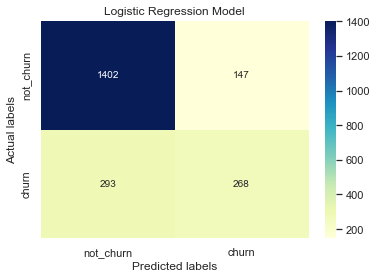

In [104]:
logistic_regression(X_train, X_test, y_train, y_test, 'None')

Sampling: SMOTEENN
              precision    recall  f1-score   support

           0       0.93      0.64      0.76      1549
           1       0.47      0.87      0.61       561

    accuracy                           0.70      2110
   macro avg       0.70      0.75      0.68      2110
weighted avg       0.81      0.70      0.72      2110



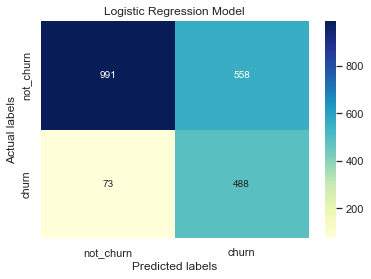

In [112]:
logistic_regression(X_train, X_test, y_train, y_test, 'Smoteenn')

Sampling: UPSAMPLING
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1549
           1       0.51      0.80      0.62       561

    accuracy                           0.74      2110
   macro avg       0.71      0.76      0.71      2110
weighted avg       0.80      0.74      0.75      2110



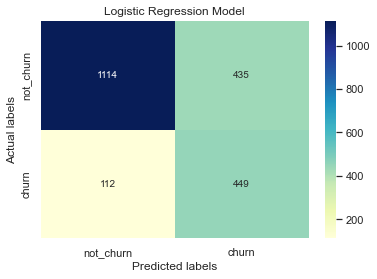

In [129]:
logistic_regression(X_train, X_test, y_train, y_test, 'Upsampling')

* Testing using Artificial Neural Network

Epoch 1/100
154/154 [==============================] - 1s 5ms/step - loss: 0.4413 - accuracy: 0.7861
Epoch 2/100
154/154 [==============================] - 1s 5ms/step - loss: 0.4170 - accuracy: 0.7999
Epoch 3/100
154/154 [==============================] - 1s 5ms/step - loss: 0.4111 - accuracy: 0.8041
Epoch 4/100
154/154 [==============================] - 1s 5ms/step - loss: 0.4022 - accuracy: 0.8050
Epoch 5/100
154/154 [==============================] - 1s 5ms/step - loss: 0.3965 - accuracy: 0.8098
Epoch 6/100
154/154 [==============================] - 1s 5ms/step - loss: 0.3894 - accuracy: 0.8139
Epoch 7/100
154/154 [==============================] - 1s 4ms/step - loss: 0.3813 - accuracy: 0.8174
Epoch 8/100
154/154 [==============================] - 1s 4ms/step - loss: 0.3736 - accuracy: 0.8178
Epoch 9/100
154/154 [==============================] - 1s 5ms/step - loss: 0.3623 - accuracy: 0.8269
Epoch 10/100
154/154 [==============================] - 1s 5ms/step - loss: 0.3490 - accura

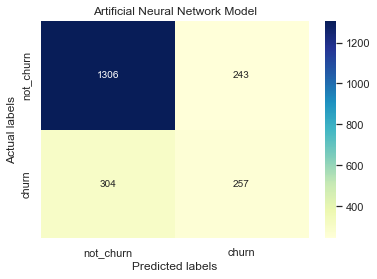

In [125]:
ann(X_train, X_test, y_train, y_test, 'None')

> Sampling = 'Smoteenn'

Epoch 1/100
143/143 [==============================] - 1s 5ms/step - loss: 0.2304 - accuracy: 0.9088
Epoch 2/100
143/143 [==============================] - 1s 5ms/step - loss: 0.1645 - accuracy: 0.9364
Epoch 3/100
143/143 [==============================] - 1s 5ms/step - loss: 0.1374 - accuracy: 0.9458
Epoch 4/100
143/143 [==============================] - 1s 5ms/step - loss: 0.1127 - accuracy: 0.9529
Epoch 5/100
143/143 [==============================] - 1s 5ms/step - loss: 0.0863 - accuracy: 0.9675
Epoch 6/100
143/143 [==============================] - 1s 5ms/step - loss: 0.0692 - accuracy: 0.9721
Epoch 7/100
143/143 [==============================] - 1s 5ms/step - loss: 0.0547 - accuracy: 0.9807
Epoch 8/100
143/143 [==============================] - 1s 5ms/step - loss: 0.0411 - accuracy: 0.9849
Epoch 9/100
143/143 [==============================] - 1s 5ms/step - loss: 0.0332 - accuracy: 0.9879
Epoch 10/100
143/143 [==============================] - 1s 5ms/step - loss: 0.0413 - accura

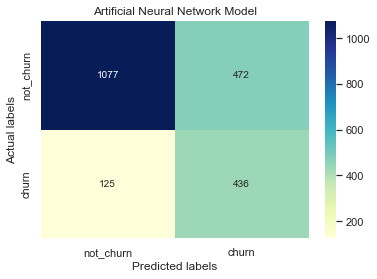

In [126]:
ann(X_train, X_test, y_train, y_test, 'Smoteenn')

> Sampling = 'Upsampling'

Epoch 1/100
226/226 [==============================] - 1s 5ms/step - loss: 0.4906 - accuracy: 0.7594
Epoch 2/100
226/226 [==============================] - 1s 5ms/step - loss: 0.4551 - accuracy: 0.7821
Epoch 3/100
226/226 [==============================] - 1s 5ms/step - loss: 0.4347 - accuracy: 0.7955
Epoch 4/100
226/226 [==============================] - 1s 5ms/step - loss: 0.4061 - accuracy: 0.8138
Epoch 5/100
226/226 [==============================] - 1s 5ms/step - loss: 0.3779 - accuracy: 0.8271
Epoch 6/100
226/226 [==============================] - 1s 6ms/step - loss: 0.3503 - accuracy: 0.8459
Epoch 7/100
226/226 [==============================] - 1s 5ms/step - loss: 0.3231 - accuracy: 0.8592
Epoch 8/100
226/226 [==============================] - 1s 5ms/step - loss: 0.3017 - accuracy: 0.8687
Epoch 9/100
226/226 [==============================] - 1s 5ms/step - loss: 0.2740 - accuracy: 0.8814
Epoch 10/100
226/226 [==============================] - 1s 5ms/step - loss: 0.2518 - accura

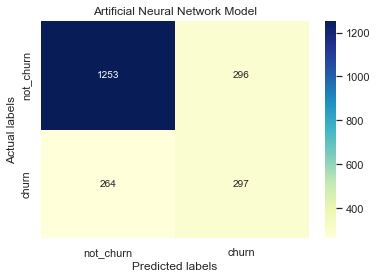

In [127]:
ann(X_train, X_test, y_train, y_test, 'Upsampling')

<a id="pick_model"></a>
***2. Picking the Model***

For this type of problem, I would focus more on the recall side of results rather than the precision for predicting `churn`. Because people leaving the business is not stonks for the company. so we would like to capture more the customers that actually left the business.

While for predicting those who `not_churn`, I would concentrate on results that gave a not so high recall or **low to moderate false churn**.

In summary: 
- Preferred `churn with high recall`
- Preferred `not_churn with low recall`

Given this insights, let's summarize the recalls for ever model

1st: Logistic Regression

| Sampling | churn (recall) | not_churn (recall)  |
|:------|:------|:------|
| None | 47% | 91% |
| Smoteen | 87% | 64% |
| Upsampling | 80% | 72% |

**2.1.1** LR with sampling = None

For this model of logistic regression with sampling `None`, the precision, and recall for predicting `not_churn` is high and It did a terrible job at predicting `churn`.

Only 258 out of 561 roughly **47%** in churn were only correctly predicted.

This model is not preferred.

**2.1.2** LR with sampling = Smoteenn

This can be a good candidate since 488/561 = **87%** is correctly predicted for churn. While **64%** for the recall of not_churn.

**2.1.3** LR with sampling = Upsampling

This model also shows an appreciable but not too high recall of 449/561 = **80%** for churn and low recall of **72%** for not_churn

2nd: Artificial Neural Network

| Sampling | churn (recall) | not_churn (recall)  |
|:------|:------|:------|
| None | 46% | 84% |
| Smoteen | 78% | 70% |
| Upsampling | 53% | 81% |

**2.2.1** ANN with sampling = None

Not preferred since it's the other way around.

**2.2.2** ANN with sampling = Smoteenn

Results were nearly balanced and churn recall not too high.

**2.2.3** ANN with sampling = Upsampling

Results are also the other way around so not preferred.

----

So far, I prefer 2 models out of 6. Both in Logistic Regression **2.1.2** and **2.1.3** with sampling Smoteenn and Upsampling.

<img height=400 width=400 src="Smoteenn.png"/>
<img height=400 width=400 src="Upsampling.png"/>

Out of this 2 I'll pick the model with sampling Smoteenn **2.1.2**.

Nani? because...

1. Recall is higher. You are assured **87%** of the time how many customers actually churned out of all the customers the model said would churn.

2. It might seem worse compared to **2.1.3**(Upsampling) given its accuracy and precision for predicting churn. But that's exactly the point, I think we must expect the worst especially in this kinds of situation since it costs the company a lot of money when customers leave the business. 

3. Yes the prediction of not_churn is being compromised since false churn is somewhat high. But that's the trade-off I'm willing to take since customers leaving the company is bad for the finances of the company. I think it's better to predict a customer that they will churn even though they wouldn't. In that way we can send like promo, discounts, coupons, or raffle entries for the predicted that will churn. Especially those who are loyal to the company or predicted churn but they're not actually going to churn. They will feel great or better with the company.

4. Think of the monthly contribution of the people who will left and the expense of just sending a coupon or promo. Or (prizes or appreciation for the years of tenure the subscriber is subscribed). I think it's a good trade-off in the long run not just for the company but also for its subscribers.

But I think it's still depends on the company how much percentage for false churn they are willing to take in expense of predicting those who actually did not churn by using the **ROC curve**.

----

<a id="suggested_solutions"></a>
# SUGGESTED SOLUTIONS

1. Ask for feedback to those customers who've already churned.

2. Improve the services like the phone service with multiple lines especially the Fiber Optic service.

3. Beware of hidden charges or hidden fees.

4. Constantly (like every 3 or 4 days) remind those people with an electronic check payment method for their bill.

5. Persuade or educate those customers about security (sales talk but with good intention) to include those additional service that provides internet protection or security and added tech support especially if the customer is Senior citizen but with consent with its relatives.

6. Give promos or discounts to those new customers who chose Month-to-Month as Contract. Might lessen the probabiliy that they'll churn.